Tutorial link: https://developers.google.com/machine-learning/crash-course/classification/programming-exercise

Colab link: https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/binary_classification.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=binary_classification_tf2-colab&hl=en


In [ ]:
#@title Run on TensorFlow 2.x
#%tensorflow_version 2.x

In [4]:
#@title Load the imports

# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [4]:
# !pip install python-snappy

# Loading the dataset

In [5]:
train_df = pd.read_csv("/Users/bangbui/workspace/AlgorithmInPython/datasets/california_housing_train.csv")
test_df = pd.read_csv("/Users/bangbui/workspace/AlgorithmInPython/datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set
print("Load dataset done")

Load dataset done


In [6]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12369,-121.5,39.1,17.0,4251.0,899.0,3265.0,934.0,2.3,65000.0
11679,-121.3,38.6,36.0,1665.0,293.0,846.0,306.0,3.6,121600.0
13069,-121.9,37.3,52.0,1170.0,215.0,604.0,207.0,2.7,325900.0
15160,-122.3,37.5,13.0,1422.0,295.0,395.0,195.0,5.3,327800.0
1380,-117.2,32.7,52.0,55.0,18.0,65.0,22.0,1.7,112500.0


# Normalize values

In [7]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12369,-1.0,1.6,-0.9,0.7,0.9,1.6,1.1,-0.8,-1.2
11679,-0.9,1.4,0.6,-0.4,-0.6,-0.5,-0.5,-0.2,-0.7
13069,-1.2,0.8,1.9,-0.7,-0.8,-0.7,-0.8,-0.6,1.0
15160,-1.3,0.9,-1.2,-0.6,-0.6,-0.9,-0.8,0.8,1.0
1380,1.2,-1.4,1.9,-1.2,-1.2,-1.2,-1.2,-1.2,-0.8


In [8]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [9]:
#@title Double-click for possible solutions.

# We arbitrarily set the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.

threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)


# Alternatively, instead of picking the threshold
# based on raw house values, you can work with Z-scores.
# For example, the following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

# threshold_in_Z = 1.0 
# train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
# test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float)

# train_df_norm["median_house_value_is_high"].head(5)
# print("........")
# train_df_norm["median_house_value_is_high"].head()


12369   0.0
11679   0.0
13069   1.0
15160   1.0
1380    0.0
         ..
4231    0.0
2590    1.0
11319   0.0
12213   0.0
10047   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

# Represent features in feature columns

In [10]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

2021-12-12 22:04:58.869452: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-0.8039058 ,  0.7373278 ],
       [-0.15636982, -0.44893953],
       [-0.63772446, -0.67600924],
       ...,
       [ 0.24296848,  0.07033914],
       [ 0.49436295, -0.7585801 ],
       [-0.32344207,  1.151558  ]], dtype=float32)>

# Train function

In [11]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  # pop function removes the element with the specified key
  label = np.array(features.pop(label_name))
  print("features train:")
  print(features.keys())
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [12]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


# Training step

features:
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'median_house_value_is_high'],
      dtype='object')
features train:
dict_keys(['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'])
Epoch 1/20
Consider rewriting this model with the Functional API.


The `lr` argument is deprecated, use `learning_rate` instead.


Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 847us/step - loss: 0.5518 - accuracy: 0.5684
Epoch 2/20
170/170 [==============================] - 0s 816us/step - loss: 0.5044 - accuracy: 0.6354
Epoch 3/20
170/170 [==============================] - 0s 944us/step - loss: 0.4703 - accuracy: 0.6822
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4454 - accuracy: 0.7201
Epoch 5/20
170/170 [==============================] - 0s 994us/step - loss: 0.4276 - accuracy: 0.7435
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4147 - accuracy: 0.7667
Epoch 7/20
170/170 [==============================] - 0s 914us/step - loss: 0.4063 - accuracy: 0.7822
Epoch 8/20
170/170 [==============================] - 0s 863us/step - loss: 0.4013 - accuracy: 0.7939
Epoch 9/20
170/170 [==============================] - 0s 846us/step - loss: 0.3987 - accuracy: 0.8019
Epoch 10/20
170/170 [=====================

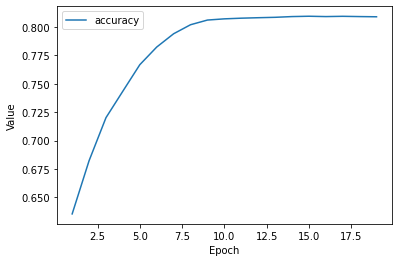

In [13]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

print("features:")
print(train_df_norm.keys())
# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [14]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
print("user features:")
print(features)
label = np.array(features.pop(label_name))
print("label:")
print(label)

print("Evaluate")
my_model.evaluate(x = features, y = label, batch_size=batch_size)

user features:
{'longitude': array([-1.2335231 ,  0.64623618,  0.89185805, ..., -0.05554062,
        1.23773376, -0.02045178]), 'latitude': array([ 0.81449726, -0.64582321, -0.87121029, ...,  0.31207189,
       -0.72095223, -0.57069418]), 'housing_median_age': array([-0.14697532,  1.1273772 , -0.14697532, ..., -1.50097488,
        0.8884361 ,  1.04773017]), 'total_rooms': array([ 0.59631903, -0.50546578,  0.45900185, ..., -0.76247159,
       -1.16143367, -0.38716888]), 'total_bedrooms': array([ 0.31528439, -0.52916722, -0.05521575, ..., -0.79140433,
       -1.24129735, -0.64224194]), 'population': array([ 0.1302239 , -0.57619979,  0.07879471, ..., -0.68876181,
       -1.31658616, -0.63054007]), 'households': array([ 0.31768141, -0.58264578,  0.0139236 , ..., -0.73862952,
       -1.30236022, -0.62916725]), 'median_income': array([ 1.51049365, -0.11230546,  1.07097096, ..., -0.81842125,
       -0.28927927,  2.56322358]), 'median_house_value': array([ 1.22749389, -0.25942677,  0.57155148,

[0.4068776071071625, 0.8003333210945129]

In [17]:
#@title Double-click for a possible answer to Task 2.

# A perfect model would make 100% accurate predictions.
# Our model makes 80% accurate predictions. 80% sounds
# good, but note that a model that always guesses 
# "median_house_value_is_high is False" would be 75% 
# accurate. 

# Add precission and recall metrics

Epoch 1/20
Consider rewriting this model with the Functional API.


/Users/bangbui/anaconda3/envs/learn_py3/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 1ms/step - loss: 0.6255 - accuracy: 0.6930 - precision: 0.4245 - recall: 0.4245
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5524 - accuracy: 0.7709 - precision: 0.5377 - recall: 0.5377
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4976 - accuracy: 0.8042 - precision: 0.6186 - recall: 0.6186
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4583 - accuracy: 0.8195 - precision: 0.6696 - recall: 0.6696
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.8271 - precision: 0.7030 - recall: 0.7030
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4170 - accuracy: 0.8326 - precision: 0.7319 - recall: 0.7319
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4074 - accuracy: 0.8330 - precision: 0.7486 - recall: 0.74

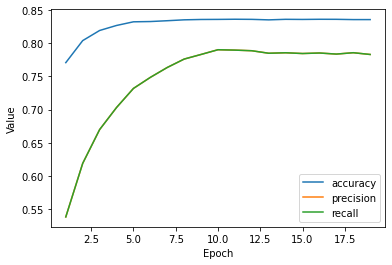

In [20]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='recall'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Add AUC

Epoch 1/20
Consider rewriting this model with the Functional API.


/Users/bangbui/anaconda3/envs/learn_py3/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 882us/step - loss: 0.5798 - auc: 0.7836
Epoch 2/20
170/170 [==============================] - 0s 876us/step - loss: 0.5236 - auc: 0.8052
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4815 - auc: 0.8193
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4512 - auc: 0.8287
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4295 - auc: 0.8340
Epoch 6/20
170/170 [==============================] - 0s 943us/step - loss: 0.4152 - auc: 0.8363
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4064 - auc: 0.8366
Epoch 8/20
170/170 [==============================] - 0s 890us/step - loss: 0.4012 - auc: 0.8368
Epoch 9/20
170/170 [==============================] - 0s 1ms/step - loss: 0.3986 - auc: 0.8369
Epoch 10/20
170/170 [==============================] - 0s 1ms/step - loss: 0.3974 - auc: 0.83

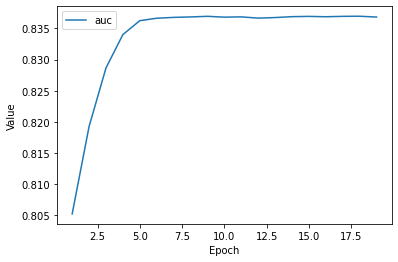

In [21]:
#@title Double-click to view the solution for Task 5.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)